We will change the input from local file to S3. It can be done with Boto3

In [ ]:
import boto3
import botocore 
import pandas as pd 
from sagemaker import get_execution_role

role = get_execution_role()

bucket = 'house-price-dataset' #Replace it with your bucket name
data_key = 'train.csv' #Replace this with your file name
data_location = 's3://house-price-dataset/train.csv'.format(bucket, data_key) 
# Replace the path with the path of your file 


# <p style="text-align:center;color:#83042d">Machine Learning Workflow</p>  <br>  
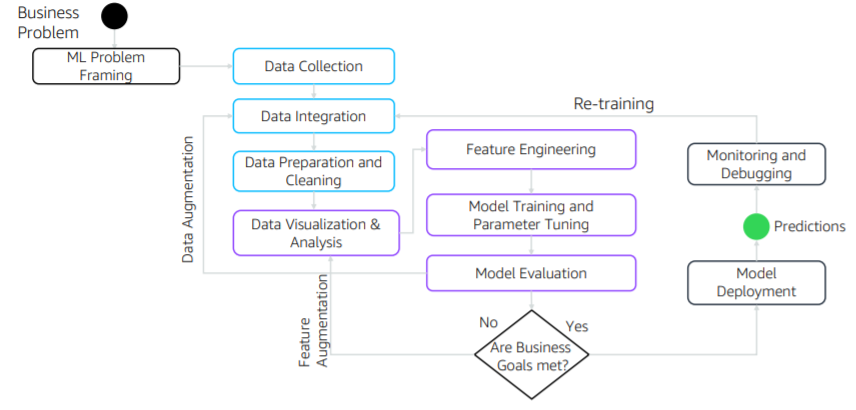 <br>

### Let us start of with Business Problem : Housing Prices
We are given data in a csv (comma separated values) file which consist of 79 explanatory variables describing (almost) every aspect of residential homes in Ames, Iowa, we have to predict the final price of each home.
<br><br>Data looks like this in a CSV file : 
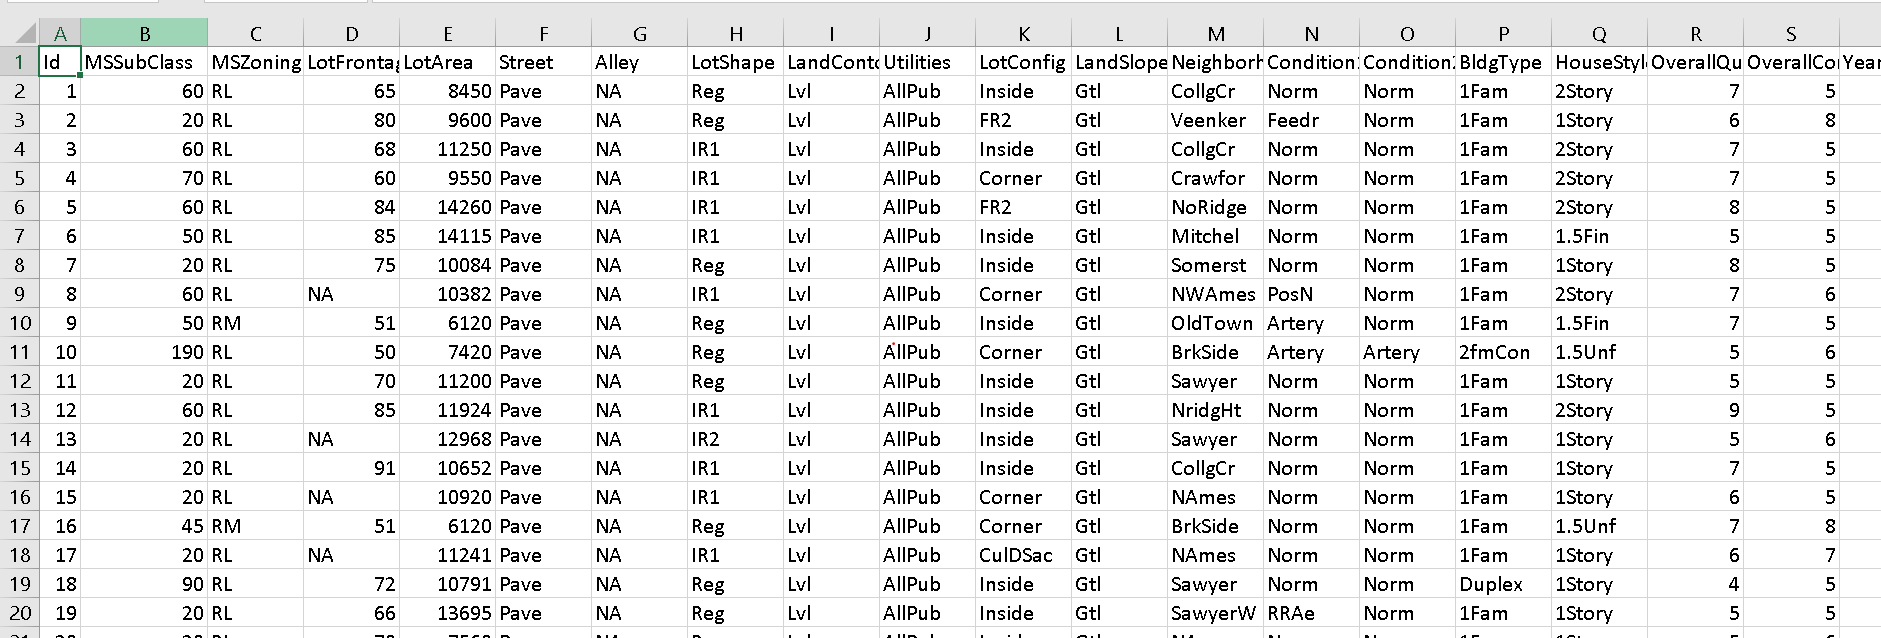

### Machine Learning Problem Framing
-> So based on the given data we need to predicte the selling price of the house.<br>
-> As the selling price can be any number like $279500 (for example) this ML problem comes under regression (will explain it down the notebook).<br>
-> Regression problem looks like this (example) : <br>
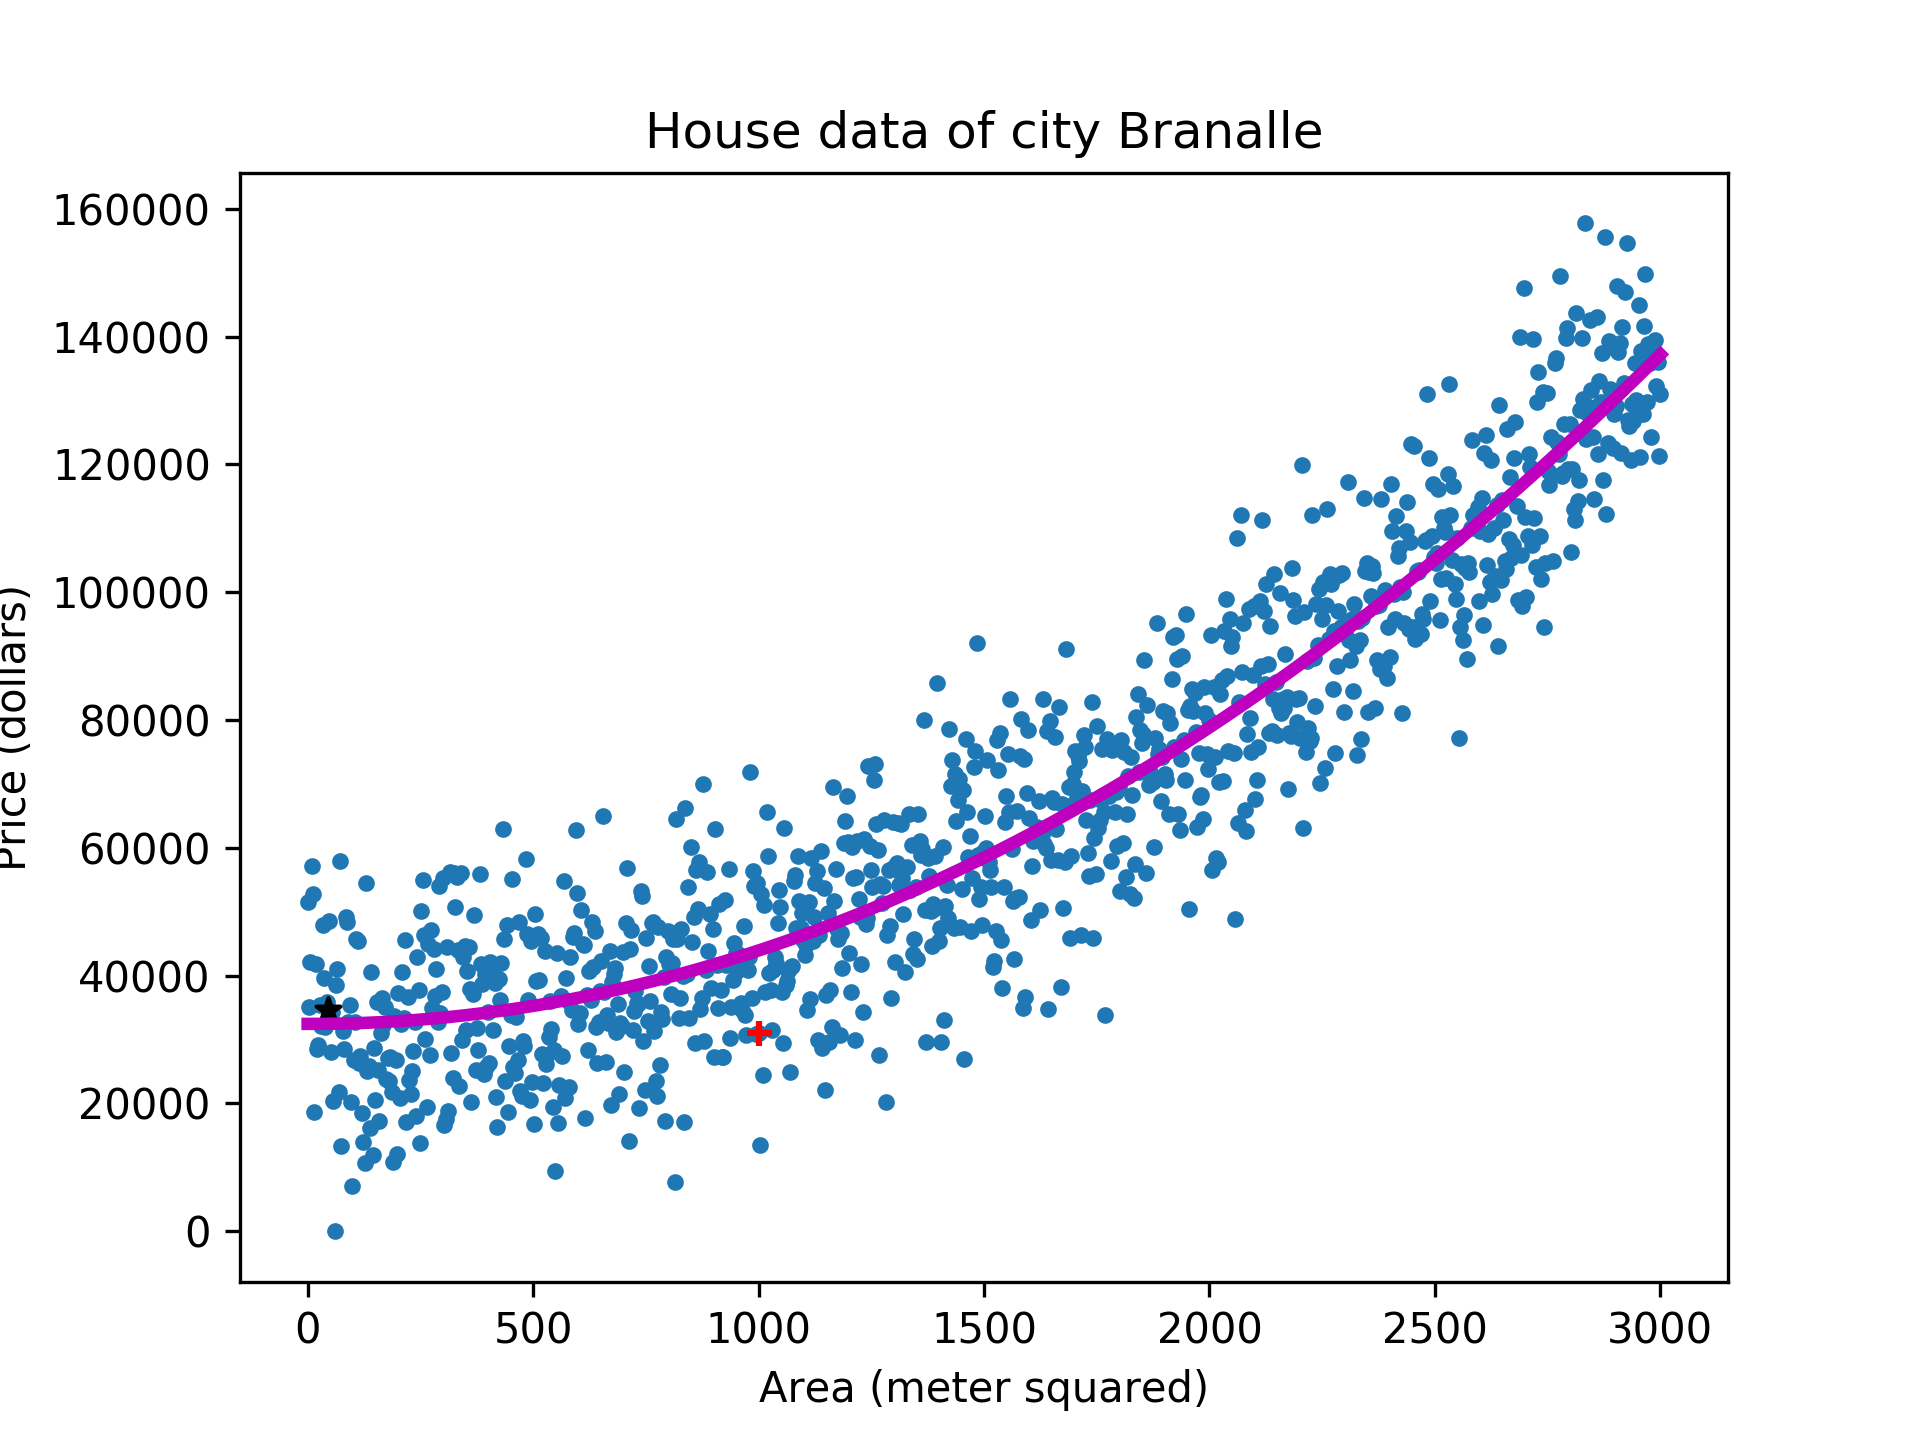
-> We will try out different regression algorithms on the data and pick the one which gives best prediction.

### Data Collection
-> The data used in this notebook is taken from https://www.kaggle.com/c/home-data-for-ml-course/overview <br>
-> We have to put the data in same folder where the notebook you are working is present.

### Data Integration
-> Some times we may have data present in many files, which is when we need to combine those into one file. <br>
-> We dont have to do it with Housing Price problem as complete data is provided in train and test csv files.<br>  (We shall see why they are provided in two files later)<br>
-> Now let us import the necessary libraries and data (which is present in same folder).

### Importing Libraries or Packages

In [ ]:
import pandas as pd # Used for handling data
import numpy as np # Used for mathematical operations
import matplotlib.pyplot as plt # Used for data plots
from sklearn.impute import SimpleImputer # To fill missing values using Imputation
import math # General Math operations are present here.
import seaborn as sns # Used for Data visualizations like creating charts of various kinds
from sklearn.impute import SimpleImputer # Used for missing values

In [ ]:
# save filepath to variable for easier access
housing_price_file_path = data_location
# read the data and store data in DataFrame titled housing_data
housing_data = pd.read_csv(housing_price_file_path) 
housing_data = housing_data.drop(housing_data.columns[0], axis=1)

### Data preparation and cleaning (also called Data Preprocessing)
-> Data preprocessing is where you study the properties of data and Try to get insight from it.


In [ ]:
# We take a peek at the training data with the head() method
housing_data.head()

In [ ]:
# print a summary of the data in Housing price data
housing_data.describe()

The results show 8 numbers for each column in your original dataset. <br>
Results are given only for colmns with numerical data.<br>
-> count :  shows how many rows have non-missing values (click here to know about missing data : [Click](https://machinelearningmastery.com/handle-missing-data-python/#:~:text=Data%20can%20have%20missing%20values,support%20data%20with%20missing%20values.)) <br>
-> mean : average of values present in particular column <br>
-> std : the standard deviation, which measures how numerically spread out the values are. <br>
-> To interpret the min, 25%, 50%, 75% and max values, imagine sorting each column from lowest to highest value. The first (smallest) value is the min. If you go a quarter way through the list, you'll find a number that is bigger than 25% of the values and smaller than 75% of the values. That is the 25% value (pronounced "25th percentile"). The 50th and 75th percentiles are defined analogously, and the max is the largest number.

In [ ]:
len(housing_data.columns)

##### dealing with missing values : There are many ways data can end up with missing values. 
Three Approaches<br>
1) Drop Columns with Missing Values<br>
    Use this option when you have lots of missing data in a column.<br>
2) Imputation<br>
    In this method we fill the missing value with a number. For instance, we can fill in the mean value along each column.<br>
3) Fill with reasonable values by observation.<br>
-> We can find "LotFrontage" and "MasVnrArea" columns to be having missing data above. We shall use Imputation to fill.<br>
-> Our collected data can heve some missing values with "NaN" tag. We cannot give it to our model, as it does not understand it.<br>
-> Pandas provides some methods specific to missing data. To select NaN entries you can use "pd.isnull()"

In [ ]:
housing_data.isnull().any()

In [ ]:
# housing_data.isnull().any() : gives us which columns have missing values 
# housing_data.columns : gives us the columns in housing data
# miscols : columns which have missing data
mis_cols = housing_data.columns[housing_data.isnull().any()]
mis_cols = list(mis_cols)
print(housing_data[mis_cols].isnull().sum())

In [ ]:
# Let us remove all the columns which have missing values greater than 100
# you get error if you run this cell again, because in first run we have deleted few columns
cols = housing_data[mis_cols].isnull().sum() > 100
remove_cols = []
for i in range(len(cols)):
    if cols[i]==True:
        remove_cols.append(mis_cols[i])
        
print(remove_cols)
housing_data.drop(remove_cols, axis=1, inplace =True)

In [ ]:
# After removing few columns we have to replace the missing values in numerical columns with mean value
mis_cols = housing_data.columns[housing_data.isnull().any()]
print('All columns with missing values less than 100 : ',mis_cols)
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
newdf = housing_data[mis_cols].select_dtypes(include=numerics)
newcol = newdf.columns
print()
print('Numerical columns with missing values less than 100 : ',newcol)
# we fill the missing cells using SimpleImputer class
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(housing_data[newcol])
housing_data[newcol] = imp.transform(housing_data[newcol])

In [ ]:
# After filling Numerical columns, let us fill categorical columns with most frequent string in column.
numerics = ['O']
mis_cols = housing_data.columns[housing_data.isnull().any()]
newdf = housing_data[mis_cols].select_dtypes(include=numerics)
newcol = newdf.columns
print(newcol)
print()
housing_data[newcol].dtypes
imp2 = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
housing_data[newcol] = imp2.fit_transform(housing_data[newcol])

In [ ]:
l = []
l.append(housing_data.columns[0])
l.append(housing_data.columns[1])
l

In [ ]:
print(housing_data.nunique())
# If we have less than 10 unique values we can avoid considering the feature as most of the cells contain the same result.
less_unique_cols = list(housing_data.nunique() < 10)
# print(less_unique_cols)
remove_cols = []
for j in range(len(less_unique_cols)):
    if less_unique_cols[j]==True:
        remove_cols.append(housing_data.columns[j])

print()
print('the columns which should be deleted : ',remove_cols)
housing_data.drop(remove_cols, axis=1, inplace =True)
housing_data.columns

### Data Visualisation
For the Data visualization we will mostly use seaborn (a powerful but easy-to-use data visualization tool). <br>
We can generate different charts with short and simple code, making seaborn much faster and easier to use than many other data visualization tools (such as Excel, for instance). 
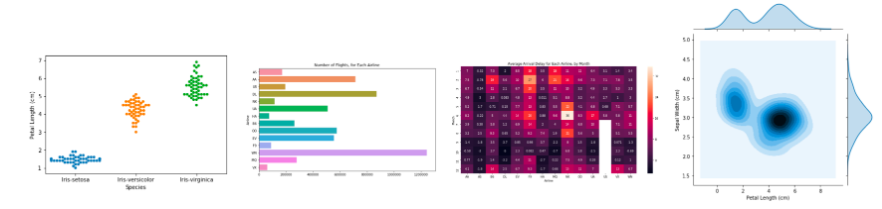 <br>

In [ ]:
pd.plotting.register_matplotlib_converters()
%matplotlib inline
print("Setup Complete")

### scatter plot
The most familiar way to visualize a bivariate distribution is a scatterplot, where each observation is shown with point at the x and y values.<br>
We will use it to see how each feature relates to the class.

In [ ]:
# Let us do it 
plt.scatter(housing_data.iloc[:,0],housing_data.iloc[:,-1],marker='o')


In [ ]:
sns.jointplot(housing_data.iloc[:,0],housing_data.iloc[:,-1],data=housing_data)

### Boxplot 
When we wanted to know the spread and median of data we use boxplot. 

In [ ]:
sns.boxplot(x=housing_data.iloc[:,0],y=housing_data.iloc[:,-1],data=housing_data)

In [ ]:
housing_data.corr()